<a href="https://colab.research.google.com/github/saghar-trade/Time-series/blob/main/VARMA_Econometrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U statsmodels

In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt


from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_excel('/content/drive/MyDrive/us_macro_quarterly.xlsx'  )
df.tail()

Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Unnamed: 0,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
223,2012:04,15539.628,94.258812,106.622,1.706667,0.173333,0.086667,7.833333,1.606433,231.277000
224,2013:01,15583.948,94.725440,106.909,1.950000,0.153333,0.086667,7.700000,1.550633,232.102667
225,2013:02,15679.677,95.992001,106.878,1.996667,0.126667,0.050000,7.500000,1.536700,232.086667
226,2013:03,15839.347,97.558537,107.387,2.710000,0.123333,0.033333,7.233333,1.552300,233.597000
227,2013:04,15965.569,NaN,107.573,2.746667,0.123333,0.063333,6.966667,1.619367,234.092333


In [5]:
def parse_date(date):
  year,quarter=date.split(":")
  month=(int(quarter)-1)*3+1
  s=f"{year}-{month}"
  return datetime.strptime(s,'%Y-%m')

In [6]:
df['Date']=df['Unnamed: 0'].apply(parse_date)


In [7]:
df.set_index(df['Date'],inplace=True)
df.drop(['Date','Unnamed: 0'], axis=1, inplace=True)

In [8]:
df.index.freq='QS'

In [9]:
df.head()

,GDPC96,JAPAN_IP,PCECTPI,GS10,GS1,TB3MS,UNRATE,EXUSUK,CPIAUCSL
Date,,,,,,,,,
1957-01-01,2851.778,8.414363,16.449,3.403333,3.390000,3.096667,3.933333,NaN,27.776667
1957-04-01,2845.453,9.097347,16.553,3.626667,3.540000,3.140000,4.100000,NaN,28.013333
1957-07-01,2873.169,9.042708,16.687,3.926667,3.963333,3.353333,4.233333,NaN,28.263333
1957-10-01,2843.718,8.796834,16.773,3.633333,3.586667,3.310000,4.933333,NaN,28.400000
1958-01-01,2770.000,8.632918,16.978,3.040000,2.160000,1.756667,6.300000,NaN,28.736667


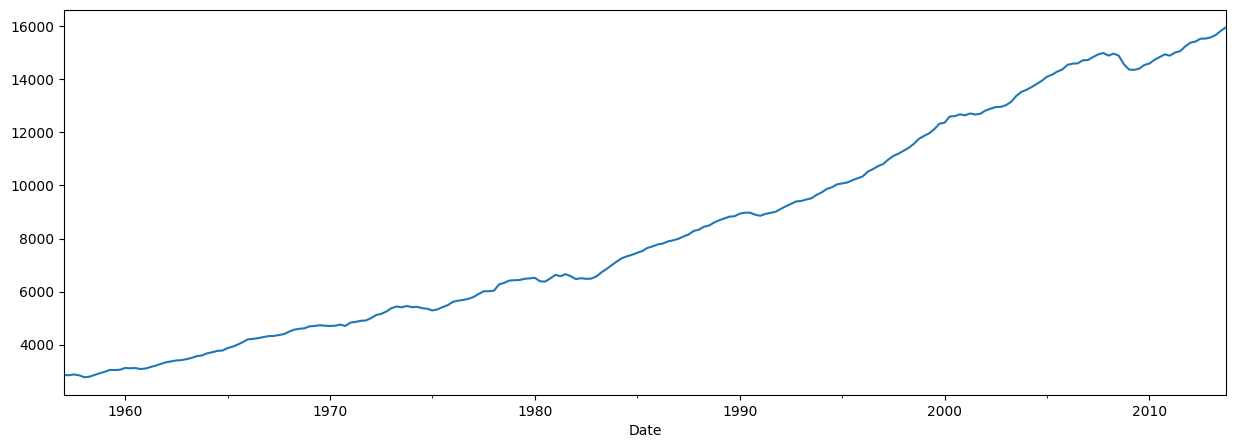

In [10]:
df['GDPC96'].plot(figsize=(15,5));

In [11]:
df['GDPGrowth']=np.log(df['GDPC96']).diff()
df['TSpread']=df['GS10']-df['TB3MS']

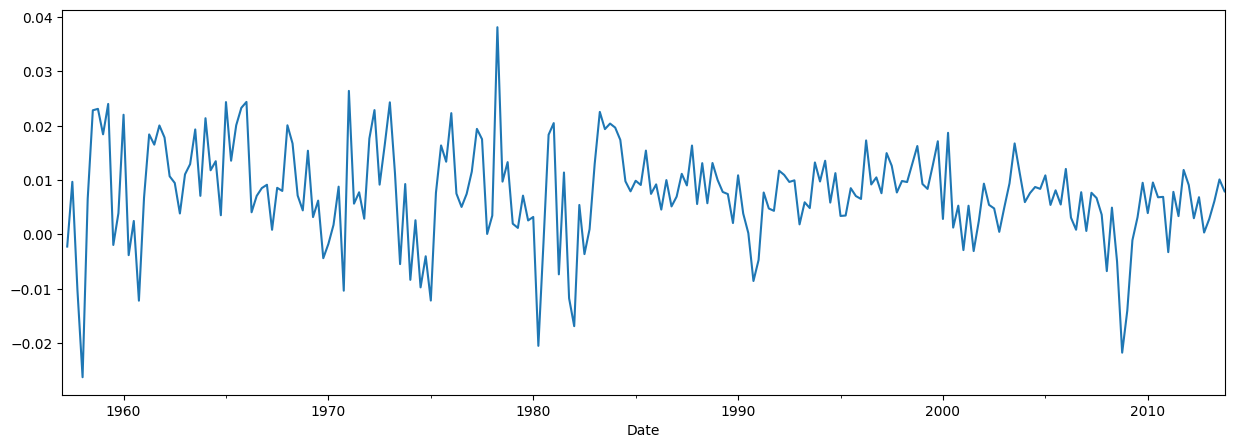

In [12]:
df['GDPGrowth'].plot(figsize=(15,5));

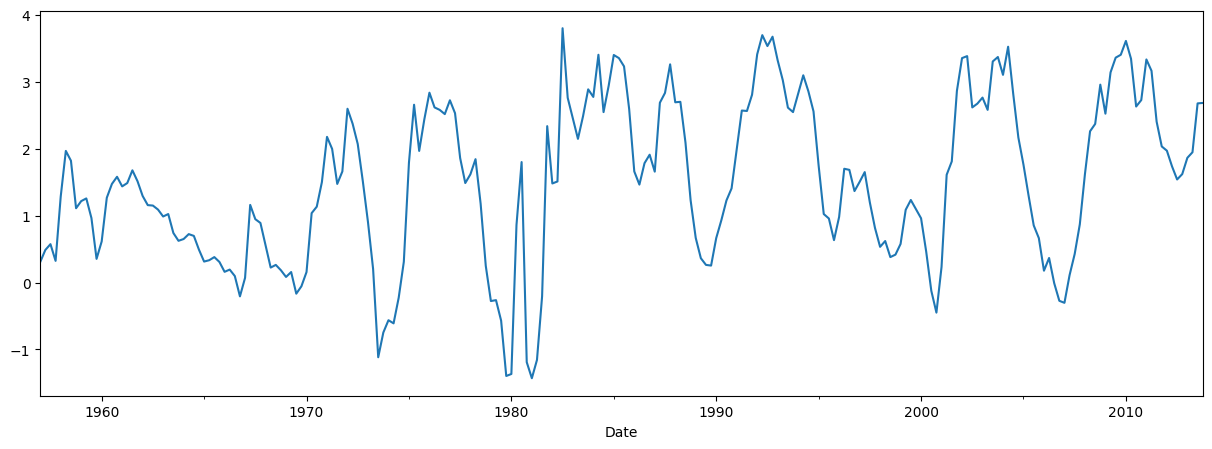

In [13]:
df['TSpread'].plot(figsize=(15,5));

In [14]:
cols=['GDPGrowth','TSpread']

In [15]:
df1=df.iloc[1:][cols].copy()

In [16]:
Ntest=12
train=df1.iloc[:-Ntest].copy()
test=df1.iloc[-Ntest:].copy()

In [17]:
train_idx=df1.index <= train.index[-1]
test_idx=df1.index > train.index[-1]

In [18]:
scaler=StandardScaler()
train[cols]=scaler.fit_transform(train)
test[cols]=scaler.transform(test)

In [19]:
df1.loc[train_idx,:]=train
df1.loc[test_idx,:]=test

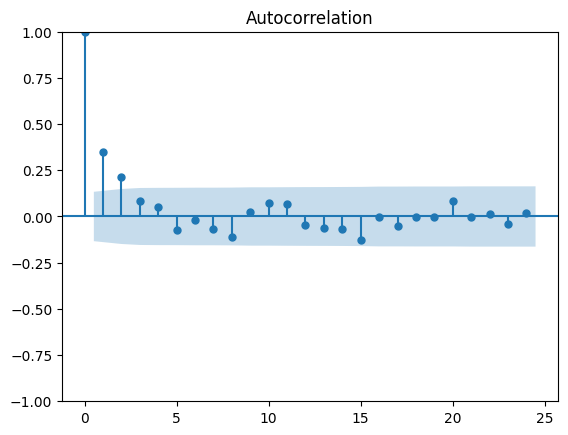

In [20]:
plot_acf(train['GDPGrowth']);

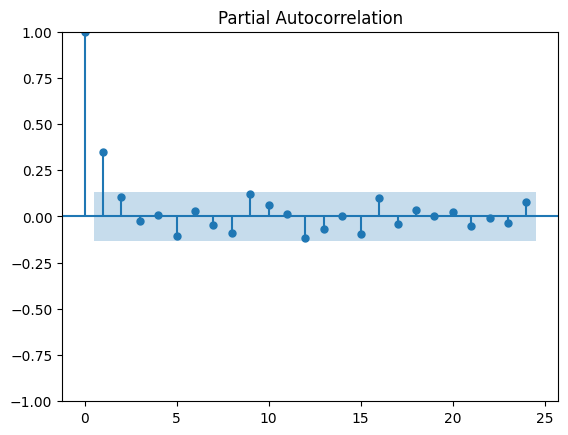

In [21]:
plot_pacf(train['GDPGrowth']);

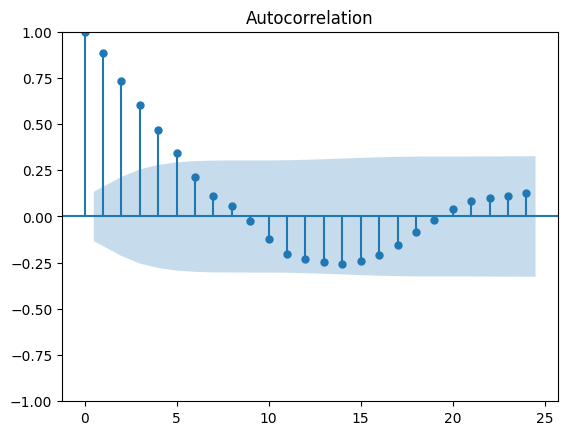

In [22]:
plot_acf(train['TSpread']);

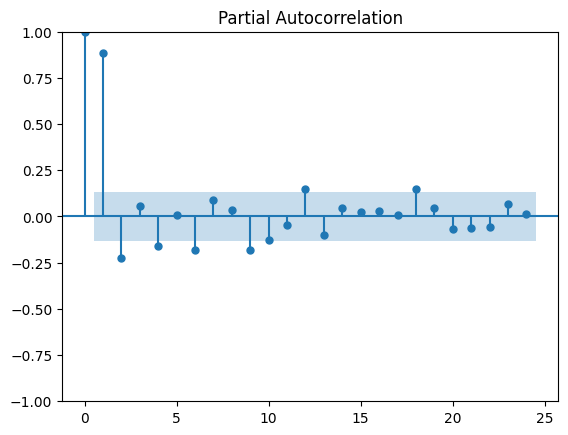

In [23]:
plot_pacf(train['TSpread']);

In [24]:
adfuller(train['GDPGrowth'])

(np.float64(-7.44663965462558),
 np.float64(5.814896580913866e-11),
 1,
 213,
 {'1%': np.float64(-3.461429147102264),
  '5%': np.float64(-2.875206950587861),
  '10%': np.float64(-2.5740544497344002)},
 np.float64(512.854231063742))

In [25]:
adfuller(train['TSpread'])

(np.float64(-4.001020795475584),
 np.float64(0.001405175490749345),
 12,
 202,
 {'1%': np.float64(-3.4631437906252636),
  '5%': np.float64(-2.8759570379821047),
  '10%': np.float64(-2.574454682874228)},
 np.float64(246.36949884218734))

####VARMAX

In [26]:
p=18
q=1

In [27]:
t0=datetime.now()
model=VARMAX(train[cols], order=(p,q))
res=model.fit(maxiter=100)
print("Duration: ", datetime.now()-t0)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration:  0:01:30.486531


In [28]:
fcast=res.get_forecast(Ntest)

In [29]:
df1.loc[train_idx, 'Train_pred_GDPGrowth']=res.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test_pred_GDPGrowth']=fcast.predicted_mean['GDPGrowth']

In [30]:
print(df1['GDPGrowth'].tail(10))


Date
2011-07-01   -0.476173
2011-10-01    0.460411
2012-01-01    0.154576
2012-04-01   -0.519346
2012-07-01   -0.092169
2012-10-01   -0.809287
2013-01-01   -0.535333
2013-04-01   -0.174147
2013-07-01    0.267715
2013-10-01    0.025774
Freq: QS-JAN, Name: GDPGrowth, dtype: float64


In [31]:
print(df1.iloc[-100:]['GDPGrowth'].describe())


count    100.000000
mean      -0.167441
std        0.686849
min       -3.246885
25%       -0.473943
50%       -0.077798
75%        0.219389
max        1.213739
Name: GDPGrowth, dtype: float64


<Axes: xlabel='Date'>

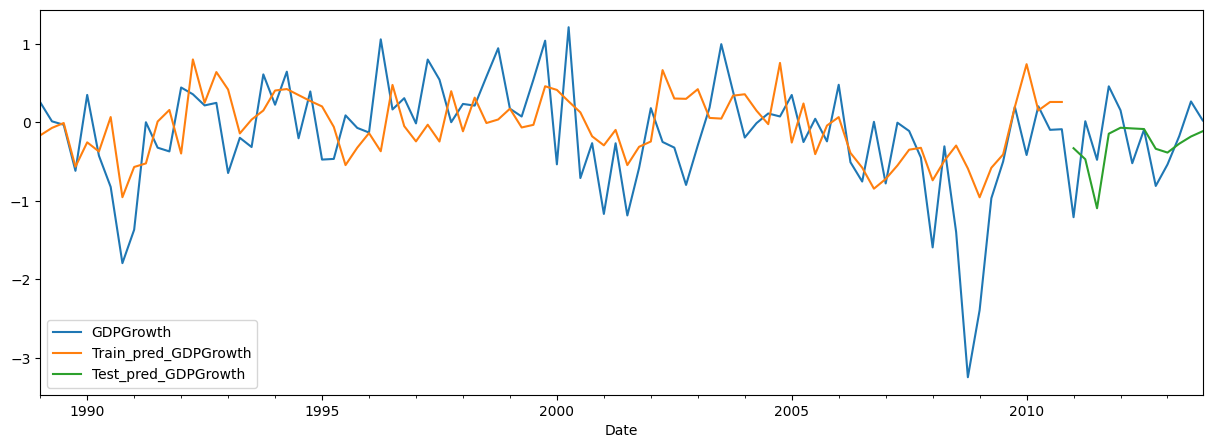

In [32]:
plot_cols=['GDPGrowth','Train_pred_GDPGrowth','Test_pred_GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [33]:
df1.loc[train_idx, 'Train_pred_TSpread']=res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test_pred_TSpread']=fcast.predicted_mean['TSpread']

<Axes: xlabel='Date'>

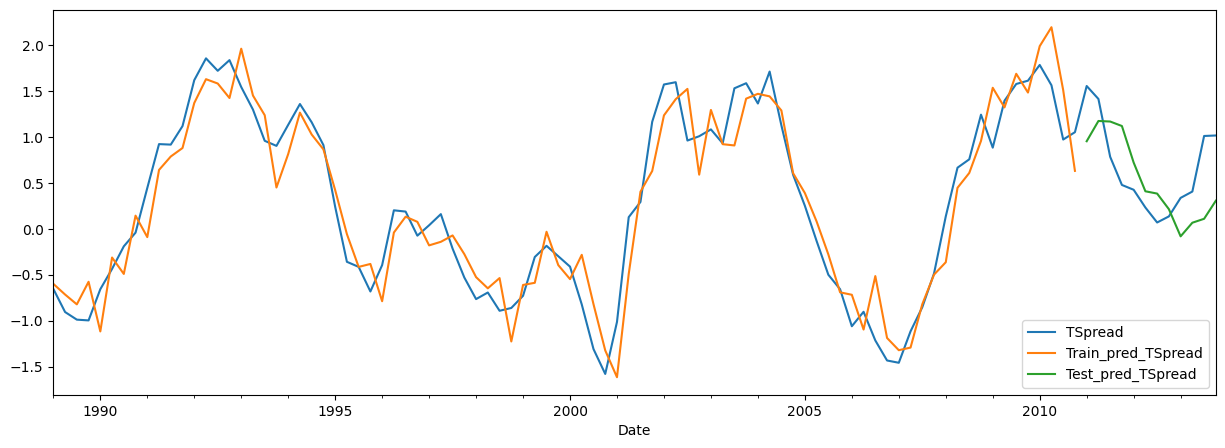

In [34]:
plot_cols=['TSpread','Train_pred_TSpread','Test_pred_TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [37]:
for col in cols:
  y_true=df1.loc[train_idx, col]
  y_pred=res.fittedvalues[col]
  print(' Train R^2 :', r2_score(y_true,y_pred))

  y_true=df1.loc[test_idx, col]
  y_pred=fcast.predicted_mean[col]
  print(' Test R^2 :', r2_score(y_true,y_pred))

 Train R^2 : 0.27640326662227777
 Test R^2 : 0.028505375898127405
 Train R^2 : 0.8736847241901167
 Test R^2 : -0.04092709861549082


####VAR

In [38]:
model_v=VAR(train[cols])

In [39]:
lag_order_results=model_v.select_order(maxlags=15)
lag_order_results

In [40]:
lag_order_results.selected_orders

{'aic': np.int64(10),
 'bic': np.int64(1),
 'hqic': np.int64(2),
 'fpe': np.int64(10)}

In [41]:
results=model_v.fit(maxlags=15,ic='aic')

In [42]:
lag_order=results.k_ar
prior=train.iloc[-lag_order:][cols].to_numpy()
fcast=results.forecast(prior, Ntest)

In [ ]:
df1.loc[train_idx, 'Train_pred_GDPGrowth']=results.fittedvalues['GDPGrowth']
df1.loc[test_idx, 'Test_pred_GDPGrowth']=fcast[:,0]

<Axes: xlabel='Date'>

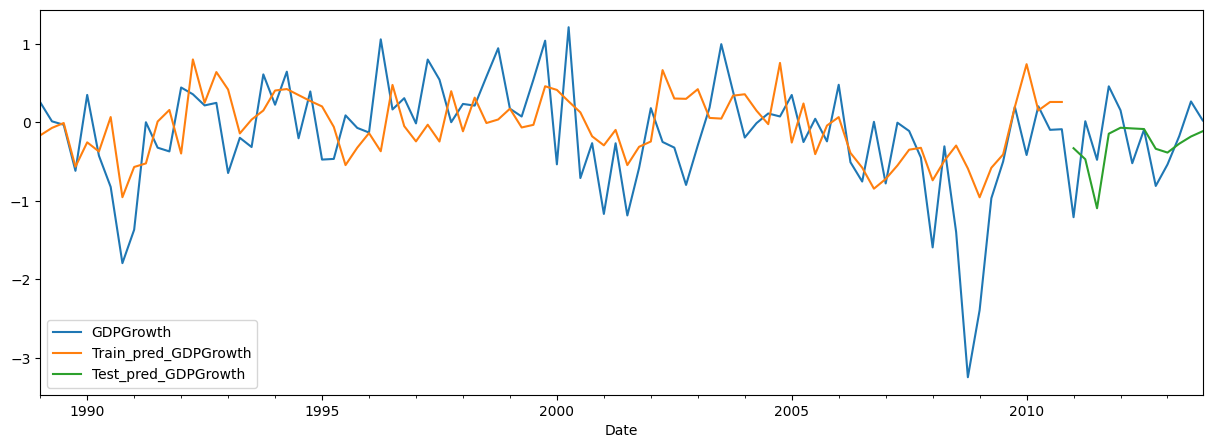

In [43]:
plot_cols=['GDPGrowth','Train_pred_GDPGrowth','Test_pred_GDPGrowth']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [45]:
df1.loc[train_idx, 'Train_pred_TSpread']=res.fittedvalues['TSpread']
df1.loc[test_idx, 'Test_pred_TSpread']=fcast[:,1]

<Axes: xlabel='Date'>

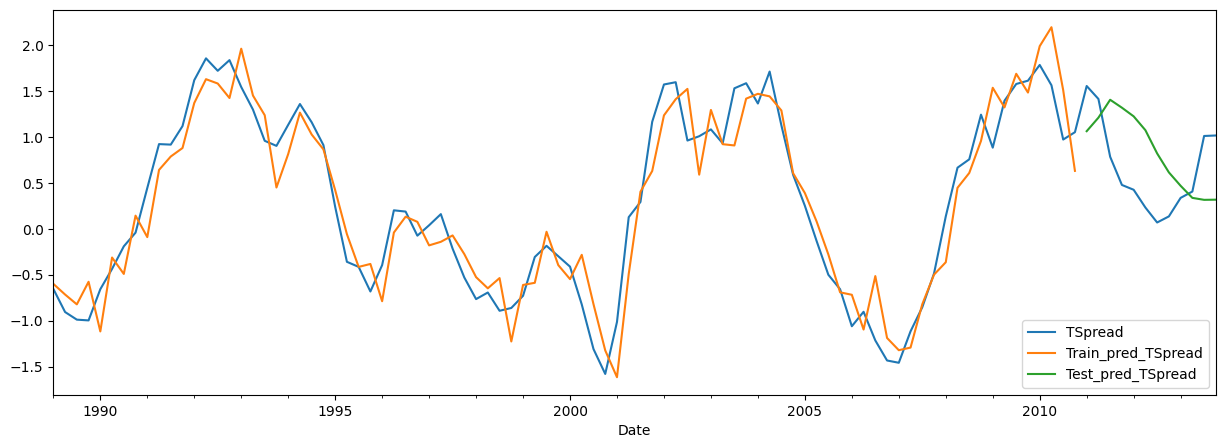

In [46]:
plot_cols=['TSpread','Train_pred_TSpread','Test_pred_TSpread']
df1.iloc[-100:][plot_cols].plot(figsize=(15,5))

In [49]:
y_pred=df1.loc[train_idx, 'Train_pred_GDPGrowth']
y_pred.iloc[lag_order:]

y_true=df1.loc[train_idx, 'GDPGrowth']
y_true.iloc[lag_order:]

print('GDPGrowth Train R^2 :', r2_score(y_true, y_pred))

#---------------------------------------------

y_pred=df1.loc[test_idx, 'Test_pred_GDPGrowth']
y_pred.iloc[lag_order:]

y_true=df1.loc[test_idx, 'GDPGrowth']
y_true.iloc[lag_order:]

print('GDPGrowth Test R^2 :', r2_score(y_true, y_pred))

GDPGrowth Train R^2 : 0.27640326662227777
GDPGrowth Test R^2 : 0.028505375898127405


In [48]:
y_pred=df1.loc[train_idx, 'Train_pred_TSpread']
y_pred.iloc[lag_order:]

y_true=df1.loc[train_idx, 'TSpread']
y_true.iloc[lag_order:]
#ignoring nan values
# mask = ~y_true.isna() & ~np.isnan(y_pred)
# r2 = r2_score(y_true[mask], y_pred[mask])
print('TSpread Train R^2 :', r2_score(y_true, y_pred))

#---------------------------------------------

y_pred=df1.loc[test_idx, 'Test_pred_TSpread']
y_pred.iloc[lag_order:]

y_true=df1.loc[test_idx, 'TSpread']
y_true.iloc[lag_order:]

print('TSpread Test R^2 :', r2_score(y_true, y_pred))

TSpread Train R^2 : 0.8736847241901167
TSpread Test R^2 : -0.671732865971082


####ARIMA BASELINE

In [50]:
for col in cols:
  model=ARIMA(train[col], order=(p,0,q))
  res=model.fit()
  fcast=res.get_forecast(Ntest)
  print(f"{col} Train R^2 : ", r2_score(df1.loc[train_idx , col], res.fittedvalues))
  print(f"{col} Test R^2 : ", r2_score(df1.loc[test_idx , col], fcast.predicted_mean))

GDPGrowth Train R^2 :  0.20569396210793944
GDPGrowth Test R^2 :  -0.8486484520613413
TSpread Train R^2 :  0.8332486531715736
TSpread Test R^2 :  -2.9963834827730675
